# SOM Clustering Visualisations
Here we describe our developments of k-means and hierarchical clustering visualisations for SOMs using the `MiniSOM` library, and provide examples on the 10-clusters dataset andd.  

## Visualisation functions
We use matplotlib for plotting and numpy for data manipulation. We use sklearn for k-means clustering, and scipy for hierarchical clustering.

In [17]:
import numpy as np
from minisom import MiniSom 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster,cut_tree
%matplotlib inline

First we define a helper function, `plot_with_labelling`, which plots a SOM according to a labelling of the units. Using this function we can easily define the visualisation functions for k-means and hierarchical clustering.

It works by iterating over the weight vectors of the given SOM, and for each it finds the winner (ie. Best Matching Unit) and plots this unit in a grid with a color according to the given color_labelling. Furthermore, it also allows for drawing border lines between units in the grid, which we will use for hierarchical clustering.

In [24]:
def plot_with_labelling(som, border_labels, coloring_labels, debug=False):
    """Given a SOM and a coloring on the units, plots a grid of the units with colors according to the labelling.
       Also draws borders between regions of different labels, according border_labels.
    Arguments:
    som -- a SOM
    d1, d2 -- dimensions of the SOM
    coloring_labels -- a list of integers where coloring_labels[i] is the label of unit i.
    border_labels -- a list of integers where border_labels[i] is the label of unit i. If border_labels is None, no borders will be drawn.
    """
    # get dimensions of the SOM
    d1 = som._neigx.shape[0]
    d2 = som._neigy.shape[0]

    rweights = som.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset
    plt.figure(figsize=(d1//2, d2//2))
    colors = ['C' + str(i) for i in np.unique(coloring_labels)]
    for cnt, xx in enumerate(rweights):
        w = som.winner(xx)  # getting the winner (BMU)
        # place a marker on the winning position for the sample xx
        plt.plot(w[0]+.5, w[1]+.5, 's', markerfacecolor=colors[coloring_labels[cnt]],
                markeredgecolor=colors[coloring_labels[cnt]], markersize=20, markeredgewidth=2)
    if debug: print("done with coloring. Proceeding to plot borders...")

    # Draw borders if needed. The algorithms works by iterating over all winning units in the grid, and checking if the
    # current unit's label differs from the label of the unit below or to the left. If so, draw a line between those.
    def plot_borders(debug=False):
        win_labels = np.zeros(shape=(d1,d2))
        for cnt, xx in enumerate (rweights):
            w = som.winner(xx)
            l = border_labels[cnt]
            win_labels[w[0],w[1]] = l

        # when not in debug mode, borders will be drawn in black always.
        border_color = lambda c : c if debug else 'black'
        for i,row in enumerate(win_labels):
            for j,v in enumerate(row):
                if j < win_labels.shape[1]-1 and v != row[j+1]:
                    plt.plot([i,i+1],[j+1,j+1], color=border_color('red'))
                if i < win_labels.shape[0]-1 and v != win_labels[i+1][j]:
                    plt.plot([i+1,i+1],[j,j+1], color=border_color('blue'))    
    if border_labels is not None:
        plot_borders(debug)
    plt.axis([0, d1, 0, d2])
    plt.show()

Then we can easily define the plotting functions for k-means and hierarchical clustering, since we simply need to call the library clustering functions on the weights of the SOM, and get the labels.

For hierarchical clustering, we want a way of visualising two sub-clusterings in one plot because this allows for better understanding of the subcluster structure. We did this by computing the cut-tree of two given cluster sizes. Now we have two labels for each unit: one for the sub-cluster, and one for the parent cluster.
In the plotting we draw borders according to sub-clusters, and color the parent clusters. This allows us to identify a parent cluster (by loooking at the color clusterings in the plot), but also any sub-clusters within this cluster (by looking at clusters induced by the borders).

In [25]:

def plot_kmeans(som, n_clusters, seed=0, debug=False):
    """
    Plots the SOM where each winning unit is colored according to its label from running k-means on the weights of the SOM.
    """
    d1 = som._neigx.shape[0]
    d2 = som._neigy.shape[0]
    rweights = som.get_weights().reshape(d1*d2,-1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed).fit(rweights)
    labels = kmeans.labels_
    if debug: print('done with k-means clustering.')
    plot_with_labelling(som,None,labels,debug=debug)

def plot_hierarchical(som, n_clusters, n_colorings, linkage_method='single', debug=False):
    """
    Computes a hierarchical clustering with n_clusters number of clusters, and plots the
    cut-tree between n_colorings and n_clusters.
    """
    assert(n_colorings <= n_clusters)
    d1 = som._neigx.shape[0]
    d2 = som._neigy.shape[0]
    rweights = som.get_weights().reshape(d1*d2,-1)
    Z = linkage(rweights, 'ward') # the clustering
    cuttree = cut_tree(Z,n_clusters=[n_colorings,n_clusters])
    coloring_labels = cuttree.T[0]
    border_labels = cuttree.T[1]
    plot_with_labelling(som,border_labels,coloring_labels,debug=debug)
#plot_hierarchical(clusters10_som_big, 10, 10)

## Examples
Using the functions above is easy. Below we try it out on the Iris dataset. 

In [27]:
data = np.genfromtxt('iris.csv', delimiter=',', usecols=(0, 1, 2, 3))
# normalise the data
data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, data)
# define a 20x20 SOM which uses the gaussian neighbourhood function. By de
som = MiniSom(20, 20, 4, sigma=2, learning_rate=0.5, neighborhood_function='gaussian', random_seed=2)
# train the SOM for 5000 iterations and use Principle Component Analysis (PCA) for initialising the weights 
som.pca_weights_init(data)
som.train_batch(data, 5000, verbose=True)  # random training


 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 3.05576597916e-05
 topographic error: 0.0


k-means visualisation (with k = 3):

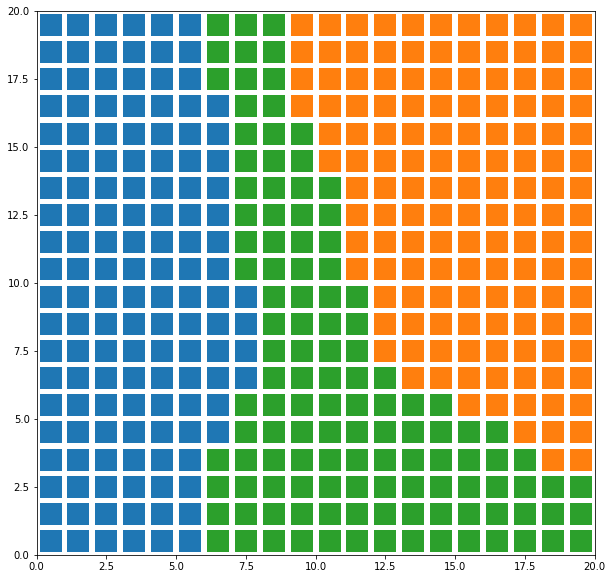

In [28]:
plot_kmeans(som, 3)

For hierarchical clustering we choose, for illustrative purposes 2 'big' clusters and 3 sub-clusters:

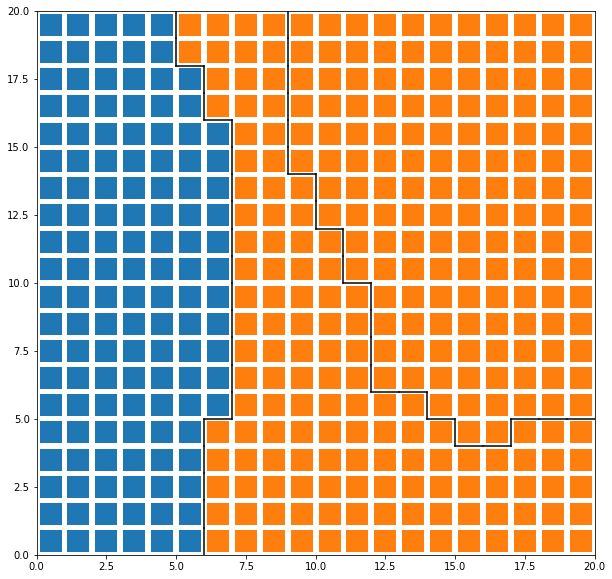

In [31]:
plot_hierarchical(som,3,2,linkage_method='single')

We see that the two sub-clusters in the orange cluster roughly correspond to the green and orange clusters from k-means, as we expect, and if the reader knows how the Iris dataset looks like, they should be convinced that this is a sensible clustering.